In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from astropy.io import fits
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator

color_map = {
    'cyan': '#66c2a5',
    'orange': '#ff7f00',
    'blue': '#8da0cb',
    'purple': '#7570b3',
    'pink': '#fccde5',
    'green': '#33a02c',
    'yellow': '#ffd92f',
    'brown': '#e5c494',
    'magenta': '#f1598a',
    'grey': '0.3'
}

In [4]:
import glob
import os
import sys
sys.path.append('../tools/')

from dust_extinction import calALambda
from spec_to_flux import spec_to_flux, spec_to_mag
from data_binning import data_binning
from visual import rcparams_format

rcparams_format(mpl.rcParams)

In [5]:
joj_bino = np.loadtxt('./data/ZTF22aajijjf_20230314_Binospec.ascii')
joj_lris = np.loadtxt('./data/ZTF22aajijjf_20230426_LRIS.ascii')
for joj in [joj_bino, joj_lris]:
    joj[:, 1] = joj[:, 1] * 10**(0.4 * calALambda(joj[:, 0], RV=3.1, EBV=0.04))
    joj[:, 2] = joj[:, 2] * 10**(0.4 * calALambda(joj[:, 0], RV=3.1, EBV=0.04))

joj_bino_bin = data_binning(joj_bino, size=5)
joj_lris_bin = data_binning(joj_lris, size=5)

z = 0.02736
MJD_peak = 59723.65
MJD_bino = 60017.42217
MJD_lris = 60061.559493
phase_bino, phase_lris = (np.array([MJD_bino, MJD_lris]) - MJD_peak) / (1 + z) + 0.51
phase_bino, phase_lris

(286.45861586979885, 329.42050167419325)

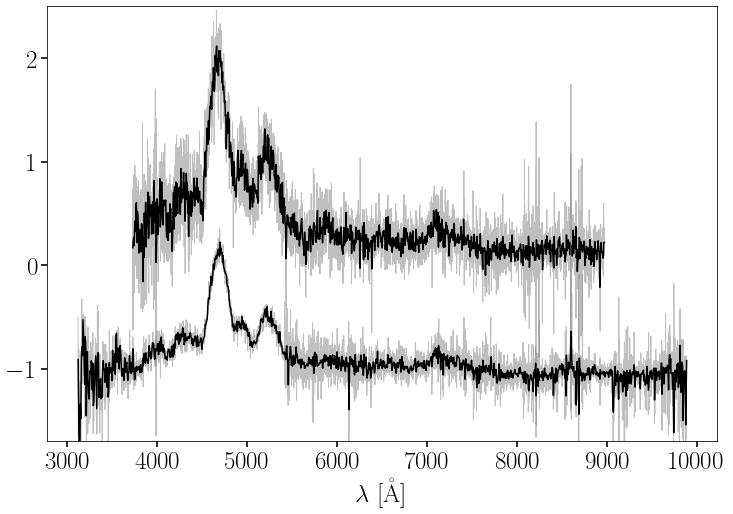

In [6]:
plt.figure(figsize=(12, 8))
for k in range(2):
    joj = [joj_bino, joj_lris][k]
    joj_bin = [joj_bino_bin, joj_lris_bin][k]
    plt.plot(joj[:, 0] / (1 + z), joj[:, 1] - k * 1.2, linewidth=1, color=".5", alpha=0.5)
    plt.plot(joj_bin[:, 0] / (1 + z), joj_bin[:, 1] - k * 1.2, color="k")
plt.xlabel(r"$\lambda\ [\mathrm{\mathring{A}}]$")
plt.ylim(-1.7, 2.5)
plt.show()

# Fit line velocities

In [7]:
from absorption_line_vel import SpectrumSN_Lines

# read spec data
z = 0.02736  # redshift
Spec_bino = SpectrumSN_Lines("./data/ZTF22aajijjf_20230314_Binospec.ascii", z, bin=True, bin_size=10,)
Spec_lris = SpectrumSN_Lines("./data/ZTF22aajijjf_20230426_LRIS.ascii", z, bin=True, bin_size=10,)

## [Co iii] 6000

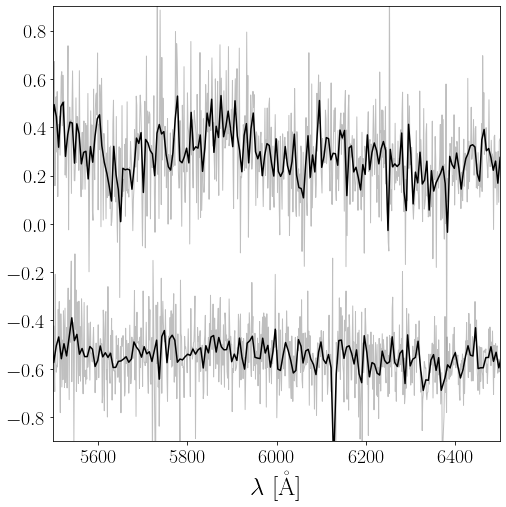

In [18]:
plt.figure(figsize=(8, 8))
for k in range(2):
    joj = [joj_bino, joj_lris][k]
    joj_bin = [joj_bino_bin, joj_lris_bin][k]
    plt.plot(joj[:, 0] / (1 + z), joj[:, 1] - k * .8, linewidth=1, color=".5", alpha=0.5)
    plt.plot(joj_bin[:, 0] / (1 + z), joj_bin[:, 1] - k * .8, color="k")
plt.xlabel(r"$\lambda\ [\mathrm{\mathring{A}}]$")
plt.ylim(-.9, .9)
# plt.axvline(6564.6, color='k')
# plt.axvline(6716.440 + 2, color='k')
plt.xlim(5500, 6500)
plt.show()

binning spectrum...
LS estimation:
Velocity 1: -847 km/s


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 16 seconds.


               mean       sd   hdi_16%   hdi_84%  mcse_mean  mcse_sd  \
v_mean[0]  -695.399  561.394 -1228.807  -131.901     12.081    8.880   
v_sig[0]   3202.076  754.101  2376.058  3832.512     21.750   15.433   
A[0]        859.054  236.633   582.941  1050.889      6.850    4.845   
sigma_0       0.100    0.032     0.076     0.134      0.001    0.001   
EW_0       -125.901   40.753  -158.274   -80.227      1.177    0.832   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  2179.099  2804.291  1.002  
v_sig[0]   1214.618  1953.179  1.003  
A[0]       1203.404  2154.447  1.002  
sigma_0    1009.640   352.590  1.004  
EW_0       1215.148  1935.665  1.002  


(-1.0, 2.1)

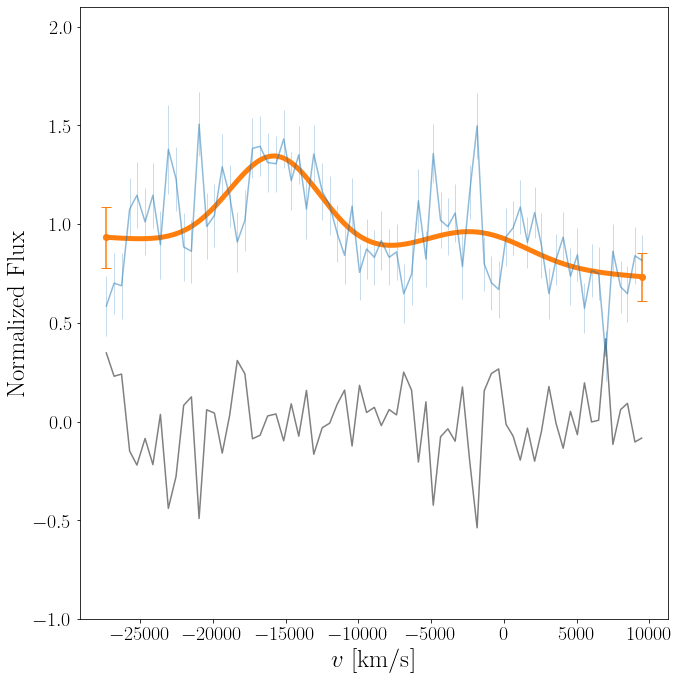

In [19]:
Spec_bino.add_line(
    "[CoIII]",
    5650,
    6400,
    lines=[[5888.48, 5906.78, 6195.45, 6127.67]],
    rel_strength=[[12.6e3, 3.82e3, 3.78e3, 2.71e3]],
)  # Table 9, Storey & Sochi 2016
Spec_bino.line["[CoIII]"].LS_estimator(guess=(1, 1, -1000, 15, 1000))
_, _, ax = Spec_bino.line["[CoIII]"].MCMC_sampler(vel_mean_mu=[0], vel_mean_sig=[1e3])
ax.set_ylim(-1, 2.1)

## [Fe ii] 7300

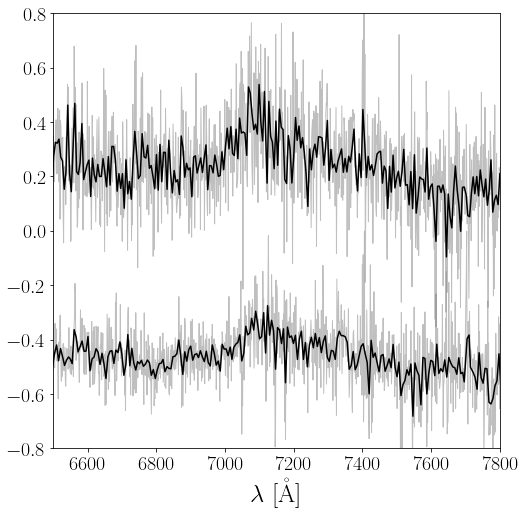

In [8]:
plt.figure(figsize=(8, 8))
for k in range(2):
    joj = [joj_bino, joj_lris][k]
    joj_bin = [joj_bino_bin, joj_lris_bin][k]
    plt.plot(joj[:, 0] / (1 + z), joj[:, 1] - k * .7, linewidth=1, color=".5", alpha=0.5)
    plt.plot(joj_bin[:, 0] / (1 + z), joj_bin[:, 1] - k * .7, color="k")
plt.xlabel(r"$\lambda\ [\mathrm{\mathring{A}}]$")
plt.ylim(-.8, .8)
# plt.axvline(6564.6, color='k')
# plt.axvline(6716.440 + 2, color='k')
plt.xlim(6500, 7800)
plt.show()

binning spectrum...
LS estimation:
Velocity 1: -10358 km/s


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 17 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.889, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


               mean        sd   hdi_16%   hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -4555.362  1111.929 -5730.642 -3513.068     28.458   20.589   
v_sig[0]   8663.603   961.357  8297.172  9998.853     26.741   18.950   
A[0]       1852.175   350.783  1502.626  2201.290      9.058    6.406   
sigma_0       0.123     0.023     0.102     0.146      0.001    0.000   
EW_0       -275.318    63.982  -333.510  -208.313      1.654    1.170   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  1504.692  1340.300  1.004  
v_sig[0]   1227.322  1498.925  1.003  
A[0]       1495.581  1937.075  1.003  
sigma_0    1810.376  1392.625  1.002  
EW_0       1479.273  1858.882  1.003  


(-0.5, 1.6)

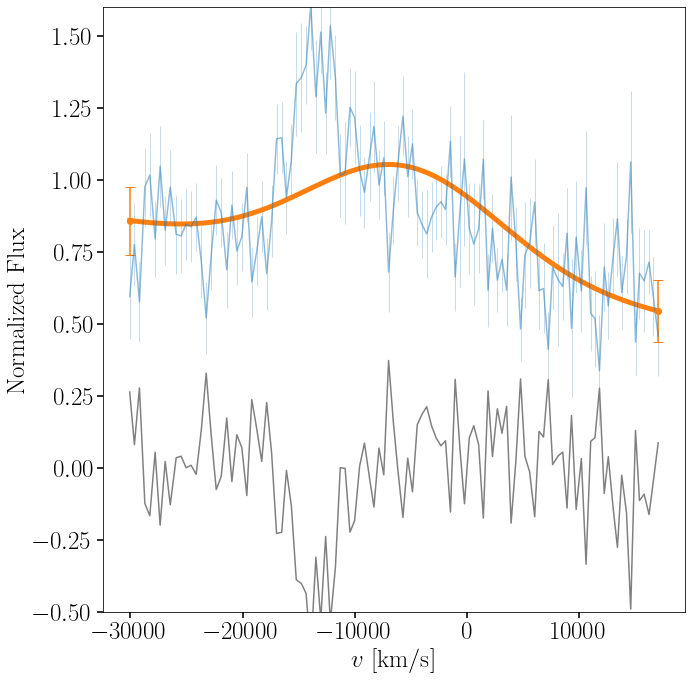

In [113]:
Spec_bino.add_line(
    "[NiII]_7300",
    6700,
    7850,
    lines=[[7378, 7412]],
    rel_strength=[[1, 0.31]],
)  # Jerkstrand et al. 2015, 2015MNRAS.448.2482J
Spec_bino.line["[NiII]_7300"].LS_estimator(guess=(1, 1, -1000, 15, 1000))
_, _, ax = Spec_bino.line["[NiII]_7300"].MCMC_sampler(
    vel_mean_mu=[-1e3], vel_mean_sig=[1e3]
)
ax.set_ylim(-.5, 1.6)

binning spectrum...
LS estimation:
Velocity 1: -2376 km/s


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 20 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5683, but should be close to 0.8. Try to increase the number of tuning steps.


               mean       sd   hdi_16%   hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -2220.125  339.245 -2545.747 -1882.678      7.526    5.322   
v_sig[0]   3223.964  350.337  2814.796  3481.739      8.952    6.400   
A[0]       1239.132  126.800  1109.339  1358.959      3.217    2.289   
sigma_0       0.043    0.024     0.016     0.068      0.001    0.000   
EW_0       -236.206   29.543  -262.346  -204.862      0.775    0.553   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  2058.419  1881.292  1.001  
v_sig[0]   1574.341  1607.112  1.001  
A[0]       1561.739  1794.691  1.001  
sigma_0    1696.698  1421.388  1.001  
EW_0       1471.840  1763.732  1.001  


(-0.5, 1.7)

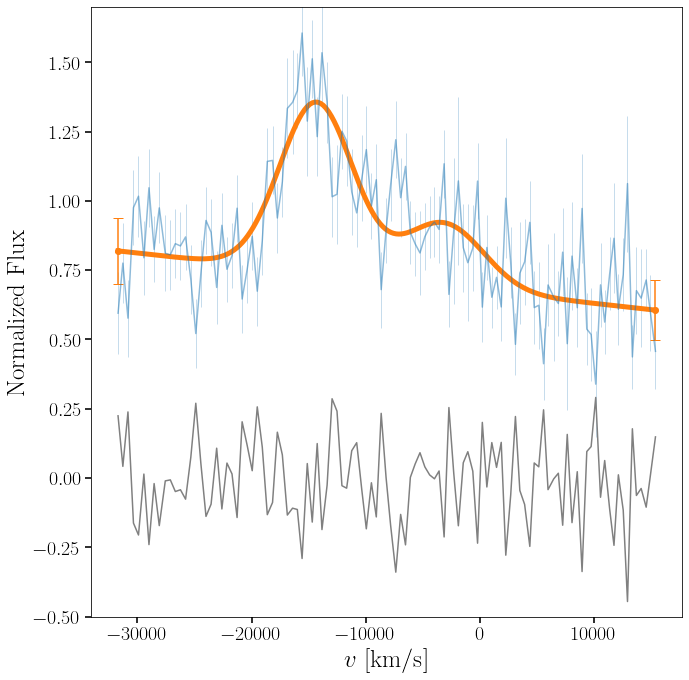

In [8]:
Spec_bino.add_line(
    "[FeII]_7300",
    6700,
    7850,
    lines=[[7155, 7172, 7388, 7453]],
    rel_strength=[[1, 0.24, 0.19, 0.31]],
)  # Jerkstrand et al. 2015, 2015MNRAS.448.2482J
Spec_bino.line["[FeII]_7300"].LS_estimator(guess=(1, 1, -1000, 15, 1000))
_, _, ax = Spec_bino.line["[FeII]_7300"].MCMC_sampler(
    vel_mean_mu=[-1e3], vel_mean_sig=[1e3]
)
ax.set_ylim(-0.5, 1.7)

binning spectrum...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 26 seconds.


               mean        sd   hdi_16%   hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -2357.211   349.829 -2711.367 -2036.472      7.981    5.645   
v_mean[1] -1148.140  1066.532 -2177.512   -92.199     19.161   14.902   
v_sig[0]   3126.533   373.593  2765.695  3474.914      9.153    6.473   
v_sig[1]   5870.097  2452.198  1755.933  7399.077     53.542   39.257   
A[0]       1202.882   153.538  1050.848  1345.877      4.140    2.982   
A[1]         51.223   221.954  -133.530   223.510      6.957    6.177   
sigma_0       0.044     0.025     0.018     0.071      0.001    0.001   
EW_0       -229.298    32.048  -259.668  -197.764      0.794    0.562   
EW_1         -7.740    31.987   -32.217    19.061      0.984    0.823   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  1992.004  1955.723  1.002  
v_mean[1]  3098.983  2560.003  1.002  
v_sig[0]   1661.045  1666.328  1.002  
v_sig[1]   2047.234  1828.428  1.001  
A[0]       1384.041  1492.683  1.005  
A[1]       1246.560   748.303  1.00

(-0.5, 1.7)

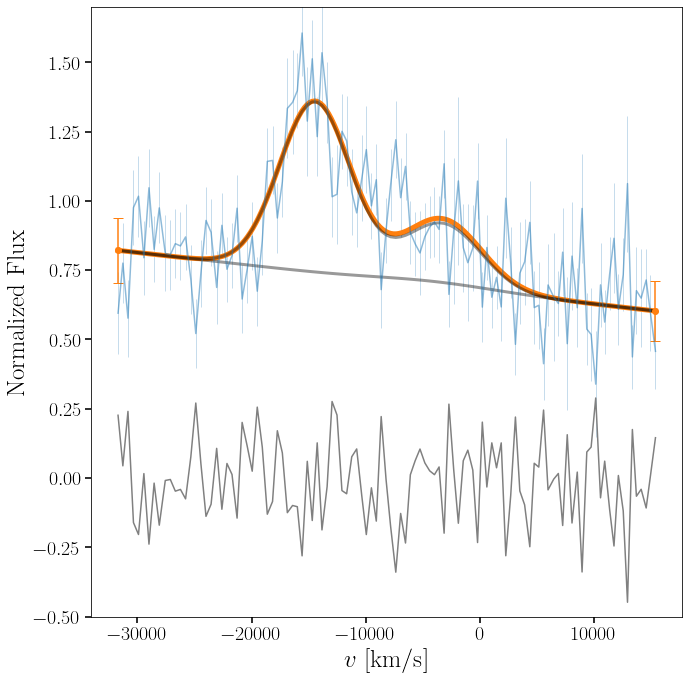

In [9]:
Spec_bino.add_line(
    "[FeII/NiII]_7300",
    6700,
    7850,
    lines=[[7155, 7172, 7388, 7453], [7378, 7412]],
    rel_strength=[[1, 0.24, 0.19, 0.31], [1, 0.31]],
)
_, _, ax = Spec_bino.line["[FeII/NiII]_7300"].MCMC_sampler(
    vel_mean_mu=[-2e3, -1e3],
    vel_mean_sig=[1e3, 1e3],
    vel_var_lim=[3e6, 1e8],
    initial=(1, 1, -1500, 15, 1000, -1000, 15, 1000),
    nburn=3000,
    A_lim=[-1e3, 1e4],
)
ax.set_ylim(-.5, 1.7)

In [14]:
post = Spec_bino.line["[FeII/NiII]_7300"].trace.posterior
EW_ratio = post['EW_1'].values.ravel()/post['EW_0'].values.ravel()

from astropy.stats import mad_std
np.mean(EW_ratio), mad_std(EW_ratio)

(0.043421571624729066, 0.10917133097983886)

(0.0022171409195354593, 0.008399041705110579)

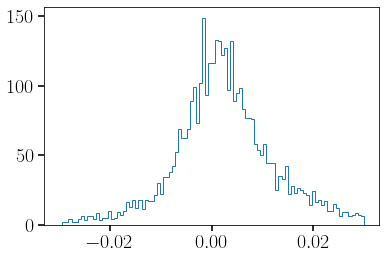

In [26]:
# tentative calculation of n(Ni)/n(Fe)
# Jerkstrand et al. 2015, 2015MNRAS.448.2482J

post = Spec_bino.line["[FeII/NiII]_7300"].trace.posterior
EW_ratio = post['EW_1'].values.ravel()/post['EW_0'].values.ravel()

L_ratio = EW_ratio.ravel() / ((1 + 0.31) / (1 + 0.24 + 0.19 + 0.31))
N = len(L_ratio)
T = np.random.rand(N) * 5000 + 3000 # electron temperature
dc = np.random.rand(N) * 1.2 + 1.2 # departure coefficient ratio
xi = np.random.rand(N) * 0.4 + 0.8 # ionization balance
k_B = 8.61733326e-5
n_ratio = L_ratio / 4.9 / dc * np.exp(-0.28 / (k_B * T)) * xi
_ = plt.hist(n_ratio, histtype="step", bins=100, range=(-0.03, 0.03))
np.median(n_ratio), mad_std(n_ratio)

binning spectrum...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 17 seconds.


               mean       sd   hdi_16%   hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -1248.783  422.465 -1685.976  -873.282      7.291    5.156   
v_sig[0]   4675.351  628.263  3977.770  5139.485     14.404   10.454   
A[0]       1504.542  156.008  1357.963  1655.393      3.698    2.649   
sigma_0       0.068    0.018     0.051     0.086      0.000    0.000   
EW_0       -249.342   32.407  -277.336  -216.288      0.776    0.558   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3402.145  2883.171  1.000  
v_sig[0]   2096.921  2057.733  1.000  
A[0]       1829.093  1815.781  1.001  
sigma_0    2601.066  1164.646  1.002  
EW_0       1815.845  1807.519  1.001  


(-1.0, 2.1)

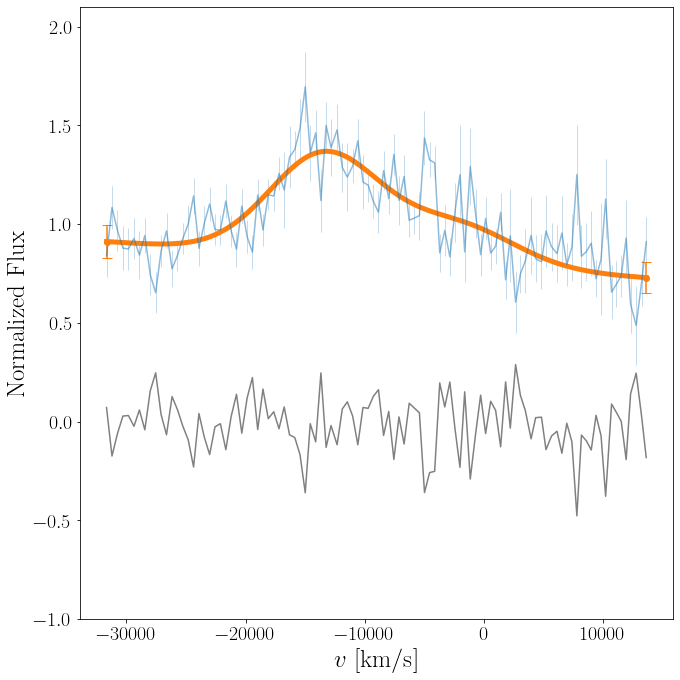

In [16]:
Spec_lris.add_line(
    "[FeII]_7300",
    6700,
    7800,
    lines=[[7155, 7172, 7388, 7453]],
    rel_strength=[[1, 0.24, 0.19, 0.31]],
)  # Jerkstrand et al. 2015
_, _, ax = Spec_lris.line["[FeII]_7300"].MCMC_sampler(
    vel_mean_mu=[-1e3], vel_mean_sig=[1e3], initial=(1, 1, -1000, 15, 1000)
)
ax.set_ylim(-1, 2.1)

binning spectrum...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 29 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


               mean        sd   hdi_16%   hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -1516.693   511.234 -2111.967 -1137.728     11.220    7.935   
v_mean[1] -1275.247  1044.886 -2266.906  -216.356     21.062   16.328   
v_sig[0]   4456.882   701.863  3670.585  4975.801     19.576   13.845   
v_sig[1]   5835.587  2536.374  1732.195  7524.013     56.182   40.184   
A[0]       1438.291   225.109  1194.925  1612.786      6.733    4.783   
A[1]        106.563   285.922  -164.280   300.258      8.098    5.727   
sigma_0       0.069     0.018     0.054     0.088      0.001    0.000   
EW_0       -238.521    40.793  -268.578  -193.822      1.195    0.848   
EW_1        -13.496    36.026   -39.153    18.843      1.009    0.714   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  2117.186  2370.538  1.001  
v_mean[1]  2467.648  2395.129  1.002  
v_sig[0]   1266.190  1962.681  1.002  
v_sig[1]   1906.563  1673.794  1.002  
A[0]       1147.149  1269.633  1.001  
A[1]       1275.000  1465.597  1.00

(-1.0, 2.1)

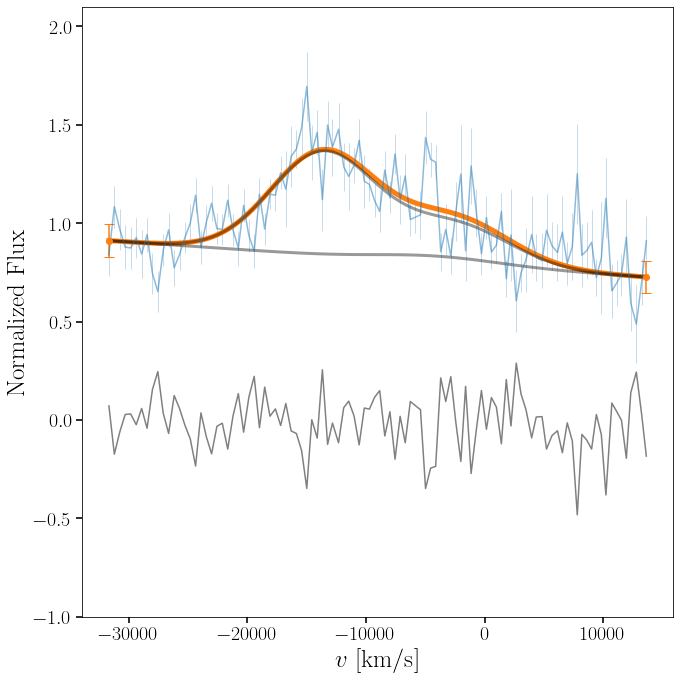

In [27]:
Spec_lris.add_line(
    "[FeII/NiII]_7300",
    6700,
    7800,
    lines=[[7155, 7172, 7388, 7453], [7378, 7412]],
    rel_strength=[[1, 0.24, 0.19, 0.31], [1, 0.31]],
)
_, _, ax = Spec_lris.line["[FeII/NiII]_7300"].MCMC_sampler(
    vel_mean_mu=[-2e3, -1e3],
    vel_mean_sig=[1e3, 1e3],
    vel_var_lim=[3e6, 1e8],
    initial=(1, 1, -1500, 15, 1000, -1000, 15, 1000),
    nburn=3000,
    A_lim=[-1e3, 1e4],
)
ax.set_ylim(-1, 2.1)

In [28]:
post = Spec_lris.line["[FeII/NiII]_7300"].trace.posterior
EW_ratio = post['EW_1'].values.ravel()/post['EW_0'].values.ravel()

from astropy.stats import mad_std
np.mean(EW_ratio), mad_std(EW_ratio)

(0.07490530855334927, 0.11327731592829586)

(0.0036739914014273993, 0.00898178623361844)

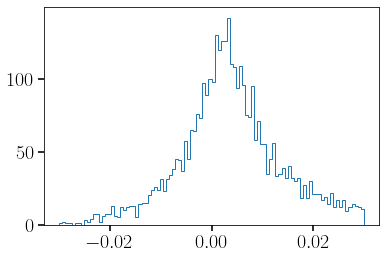

In [29]:
# tentative calculation of n(Ni)/n(Fe)
# Jerkstrand et al. 2015, 2015MNRAS.448.2482J

post = Spec_lris.line["[FeII/NiII]_7300"].trace.posterior
EW_ratio = post["EW_1"].values.ravel() / post["EW_0"].values.ravel()

L_ratio = EW_ratio.ravel() / ((1 + 0.31) / (1 + 0.24 + 0.19 + 0.31))
N = len(L_ratio)
T = np.random.rand(N) * 5000 + 3000 # electron temperature
dc = np.random.rand(N) * 1.2 + 1.2 # departure coefficient ratio
xi = np.random.rand(N) * 0.4 + 0.8 # ionization balance
k_B = 8.61733326e-5
n_ratio = L_ratio / 4.9 / dc * np.exp(-0.28 / (k_B * T)) * xi
_ = plt.hist(n_ratio, histtype="step", bins=100, range=(-0.03, 0.03))
np.median(n_ratio), mad_std(n_ratio)

## Plot

In [30]:
def wv_rf(vel_rf, lambda_0):
    """convert relative velocity to rest-frame wavelength"""
    c = 2.99792458e5
    beta = vel_rf / c
    wv = lambda_0 * ((1 + beta) / (1 - beta)) ** 0.5

    return wv


def plot_box_spec(wave, flux):
    flux_plot = np.repeat(flux, 2)
    wv_plot = wave.copy()
    wv_plot[:-1] += np.diff(wave) / 2
    wv_plot = np.append(
        wave[0] - (wave[1] - wave[0]) / 2,
        np.append(np.repeat(wv_plot[0:-1], 2), wave[-1] + (wave[-1] - wave[-2]) / 2),
    )

    return wv_plot, flux_plot


def plot_model(Line, theta, lambda_0=0, ax=None, color=[]):
    """plot the predicted absorption features

    Parameters
    ----------
    theta : array_like
        fitting parameters: flux at the blue edge, flux at the
        red edge, (mean of relative velocity, log variance,
        amplitude) * Number of velocity components

    return_ax : boolean, default=False
        whether to return the axes
        if return_ax == True, a matplotlib axes will be returned
    """

    from absorption_line_vel import flux_gauss

    # ensure high resolution in predicted model
    if len(Line.vel_rf) < 200:
        vel_rf = np.linspace(Line.vel_rf[0], Line.vel_rf[-1], 200)
    else:
        vel_rf = Line.vel_rf
    num = len(Line.rel_strength)
    theta0 = theta[: 2 + 3 * num]
    j = 2 + 3 * num
    rel_strength = Line.rel_strength.copy()
    for k, rel in enumerate(Line.free_rel_strength):
        if rel:
            for rel_s in range(len(rel_strength[k]) - 1):
                rel_strength[k][rel_s] = 10 ** theta[j]
                j += 1
    if j != len(theta):
        raise IndexError("Number of free parameters and relative strength do not match")
    model_flux = flux_gauss(
        theta0,
        rel_strength,
        Line.lambda_0,
        Line.blue_vel,
        Line.red_vel,
        vel_rf,
        Line.lines,
    )
    # model_res = (
    #     flux_gauss(
    #         theta0,
    #         rel_strength,
    #         Line.lambda_0,
    #         Line.blue_vel,
    #         Line.red_vel,
    #         Line.vel_rf,
    #         Line.lines,
    #     )
    #     - Line.norm_fl
    # )
    wv_obs, fl_obs = plot_box_spec(wv_rf(Line.vel_rf, lambda_0), Line.norm_fl)
    ax.plot(
        wv_obs, fl_obs,
        color="0.7",
        zorder=-1,
        lw=1,
    )
    model_plot = ax.plot(wv_rf(vel_rf, lambda_0), model_flux, linewidth=6, color="k")
    # ax.errorbar(
    #     [Line.vel_rf[0], Line.vel_rf[-1]],
    #     [model_flux[0], model_flux[-1]],
    #     yerr=[Line.blue_fl[1], Line.red_fl[1]],
    #     color=model_plot[0].get_color(),
    #     fmt="o",
    #     capsize=5,
    # )
    # plt.plot(Line.vel_rf, model_res, color="grey")

    if len(rel_strength) > 1:
        for k in range(len(rel_strength)):
            model_flux = flux_gauss(
                np.append(theta0[:2], theta0[2 + 3 * k : 5 + 3 * k]),
                [rel_strength[k]],
                Line.lambda_0,
                Line.blue_vel,
                Line.red_vel,
                Line.vel_rf,
                [Line.lines[k]],
            )
            ax.plot(
                wv_rf(Line.vel_rf, lambda_0),
                model_flux,
                color=color[k],
                linewidth=3,
                linestyle='--',
                zorder=10,
            )

    # plt.xlabel(r"$v\ [\mathrm{km/s}]$")
    # plt.ylabel(r"$\mathrm{Normalized\ Flux}$")
    # plt.tight_layout()
    return ax

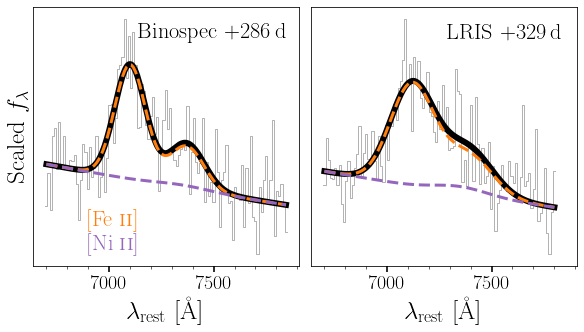

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4.5), constrained_layout=True, sharex=True)

colors = ["tab:orange", "tab:purple"]
plot_model(Spec_bino.line["[FeII/NiII]_7300"], Spec_bino.line["[FeII/NiII]_7300"].theta_MCMC, ax=ax[0], color=colors, lambda_0=7453)
plot_model(Spec_lris.line["[FeII/NiII]_7300"], Spec_lris.line["[FeII/NiII]_7300"].theta_MCMC, ax=ax[1], color=colors, lambda_0=7453)

ax[0].set_ylabel(r"$\mathrm{Scaled}\ f_\lambda$")
for a in ax:
    a.set_yticks([])
    a.set_xlabel(r"$\lambda_\mathrm{rest}\ [\mathrm{\r{A}}]$")
    a.xaxis.set_major_locator(MultipleLocator(500))
    a.xaxis.set_minor_locator(MultipleLocator(100))

ax[0].text(7140, 1.5, r"$\mathrm{Binospec}\ $+$286\,\mathrm{d}$", fontsize=22.5)
ax[1].text(7290, 1.59, r"$\mathrm{LRIS}\ $+$329\,\mathrm{d}$", fontsize=22.5)

ax[0].text(6900, 0.49, r"$\mathrm{[Fe\ \textsc{ii}]}$", color=colors[0], fontsize=22.5)
ax[0].text(6900, 0.36, r"$\mathrm{[Ni\ \textsc{ii}]}$", color=colors[1], fontsize=22.5)

plt.savefig("../paper/figures/Fe_Ni.pdf")